# Импорт библиотек

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import scipy.io
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.utils import save_image
from torch.autograd import Variable

# Загрузка данных

In [3]:
# Переведем данные в привычный нам NumPy формат
mat_data = scipy.io.loadmat('./data/frey_rawface.mat')
data = mat_data['ff'].T.reshape(-1, 1, 28, 20)
data = data.astype('float32') / 255.0
print(f"Number of instances: {len(data)}")

Number of instances: 1965


In [4]:
# Подготовка torch датасета
class FreyDataset(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return (len(self.X))
    def __getitem__(self, index):
        data = self.X[index]
        return torch.tensor(data, dtype=torch.float)

## Задание 1. Разделите данные на `train` и `val` части. К `val` отнесите последние 300 объектов. Подготовьте данные для обучения с помощью `FreyDataset` и `DataLoader`.

In [14]:
x_train = data[:-300]
x_val = data[-300:]
print(f"Training instances: {len(x_train)}")
print(f"Validation instances: {len(x_val)}")

Training instances: 1665
Validation instances: 300


In [16]:
batch_size = 64

train_loader = DataLoader(FreyDataset(x_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(FreyDataset(x_val), batch_size=batch_size, shuffle=False)

In [17]:
kernel_size = 4
stride = 1
padding = 0
init_kernel = 16 

# Вариационныей автоэнкодер

## Задание 2. Допишите трюк репараметризации в функции `reparameterize`. 

*Подробнее о трюке можно узнать в [дополнительных материалах](https://drive.google.com/file/d/18LWM4jROW6A89B7XEpH6w66M5BomGUKn/view?usp=sharing).*

In [134]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # энкодер
        self.enc1 = nn.Conv2d(
            in_channels=1, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_kernel, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_kernel*2, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_kernel*4, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc5 = nn.Conv2d(
            in_channels=init_kernel*8, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        # декодер 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_kernel*8, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_kernel*4, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_kernel*2, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec5 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=1, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )

        
    def reparameterize(self, mu, log_var):
        vector_size = log_var.size()
        eps = Variable(torch.FloatTensor(vector_size).normal_()).to('cuda')
        std = log_var.mul(0.5).exp_()
        sample =  eps.mul(std).add_(mu)
        return sample

 
    def forward(self, x):
        # кодирование
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = self.enc5(x)
        # сэмплирование среднего и logvar
        mu = x
        log_var = x
        # получаем латентное предстваление через репораметризацию
        z = self.reparameterize(mu, log_var)
 
        # декодирование
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        reconstruction = torch.sigmoid(self.dec5(x))
        return reconstruction, mu, log_var

In [135]:
lr = 0.001
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [136]:
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

## Задание 3. Прежде, чем перейти к обучению модели, определите функцию потерь VAE.

In [137]:
def final_loss(bce_loss, mu, log_var):
        KLD_element = mu.pow(2).add_(log_var.exp()).mul_(-1).add_(1).add_(log_var)
        KLD = torch.sum(KLD_element).mul_(-0.5)
        return (bce_loss + KLD)

## Обучение модели

In [138]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(x_train)/dataloader.batch_size)):
        data= data
        data = data.to(device)
        data = data
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [139]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(x_val)/dataloader.batch_size)):
            data= data
            data = data.to(device)
            data = data
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(x_val)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data[:8], 
                                  reconstruction[:8]))
                save_image(both.cpu(), f"./output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [140]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 20


27it [00:00, 49.00it/s]                        
5it [00:00, 262.49it/s]              


Train Loss: 378.7840
Val Loss: 364.2042
Epoch 2 of 20


27it [00:00, 120.75it/s]                        
5it [00:00, 245.00it/s]              


Train Loss: 361.4832
Val Loss: 355.3324
Epoch 3 of 20


27it [00:00, 121.87it/s]                        
5it [00:00, 255.78it/s]              


Train Loss: 356.5787
Val Loss: 353.8398
Epoch 4 of 20


27it [00:00, 122.94it/s]                        
5it [00:00, 234.69it/s]              


Train Loss: 354.6355
Val Loss: 352.8741
Epoch 5 of 20


27it [00:00, 121.85it/s]                        
5it [00:00, 237.85it/s]              


Train Loss: 353.7188
Val Loss: 351.2332
Epoch 6 of 20


27it [00:00, 120.30it/s]                        
5it [00:00, 253.85it/s]              


Train Loss: 353.2445
Val Loss: 351.2566
Epoch 7 of 20


27it [00:00, 118.39it/s]                        
5it [00:00, 233.51it/s]              


Train Loss: 353.0024
Val Loss: 350.8648
Epoch 8 of 20


27it [00:00, 121.36it/s]                        
5it [00:00, 240.55it/s]              


Train Loss: 352.9420
Val Loss: 351.2843
Epoch 9 of 20


27it [00:00, 117.85it/s]                        
5it [00:00, 239.01it/s]              


Train Loss: 352.8204
Val Loss: 351.1094
Epoch 10 of 20


27it [00:00, 117.93it/s]                        
5it [00:00, 249.83it/s]              


Train Loss: 352.7533
Val Loss: 350.9500
Epoch 11 of 20


27it [00:00, 121.79it/s]                        
5it [00:00, 259.43it/s]              


Train Loss: 352.7046
Val Loss: 350.5637
Epoch 12 of 20


27it [00:00, 121.15it/s]                        
5it [00:00, 235.86it/s]              


Train Loss: 352.6149
Val Loss: 351.0838
Epoch 13 of 20


27it [00:00, 120.84it/s]                        
5it [00:00, 251.23it/s]              


Train Loss: 352.5620
Val Loss: 350.7496
Epoch 14 of 20


27it [00:00, 118.30it/s]                        
5it [00:00, 250.27it/s]              


Train Loss: 352.5004
Val Loss: 351.2456
Epoch 15 of 20


27it [00:00, 118.40it/s]                        
5it [00:00, 236.71it/s]              


Train Loss: 352.6016
Val Loss: 350.6492
Epoch 16 of 20


27it [00:00, 119.81it/s]                        
5it [00:00, 247.97it/s]              


Train Loss: 352.4651
Val Loss: 350.8390
Epoch 17 of 20


27it [00:00, 117.93it/s]                        
5it [00:00, 261.22it/s]              


Train Loss: 352.5774
Val Loss: 350.3385
Epoch 18 of 20


27it [00:00, 119.25it/s]                        
5it [00:00, 257.09it/s]              


Train Loss: 352.5568
Val Loss: 350.5634
Epoch 19 of 20


27it [00:00, 118.15it/s]                        
5it [00:00, 185.62it/s]              


Train Loss: 352.5162
Val Loss: 350.9145
Epoch 20 of 20


27it [00:00, 120.13it/s]                        
5it [00:00, 251.78it/s]              

Train Loss: 352.3644
Val Loss: 350.3723


## Визуализация полученных изображений

In [141]:
from PIL import Image
import matplotlib.pyplot as plt

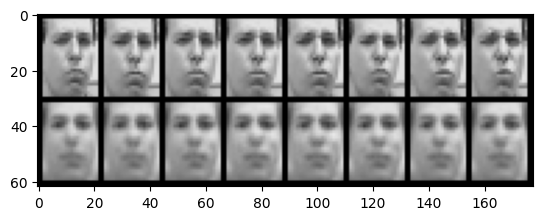

In [142]:
# 10я эпоха
image_10 = Image.open("output10.png")
plt.imshow(image_10)

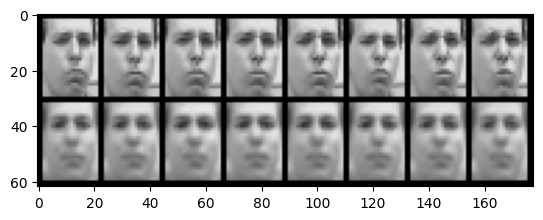

In [143]:
# 19я эпоха
image_19 = Image.open("output19.png")
plt.imshow(image_19)